# Background																			

- 1	The adjacent 3 tabs contain a data dump of search strings used by EXP clients to access relevant content available on Gartner.com for the months of August, September and October in the year 2018. Every row mentions if the EXP client is "Premium" or not, Persona (that was used for data extraction for EXP clients from main database), day on which the search string was used and finally the search string. In total there are 68544 rows of data available across all the months.																		
## Task 1																			

- 2	Clean the dataset using standard text cleaning steps and process the data to allow for the following analysis.																		
- 3	Identify the most popular topics being searched for by EXP clients and plot the top 10 topics by their frequency of occurrence.																		

- 4	Report on the volume growth of these topics over August, September and October.																		
## Task 2																			

- 5	Used the cleaned dataset from Step 2 and process your dataset for the following analysis. 																		
- 6	Use the concept of Named Entity Recognition in your code to identify a list of geographies and organizations being mentioned in the search terms.																		

- 7	Plot the geographies and organizations by their frequency of occurrence (count 1 mention of a geography, if the same geography is mentioned more than once in the same search string). If you can do it for the mention of "technologies" such as ai, analytics etc. then it will be a plus. Any useful trends observed in these mentions of geographies, organizations and technologies should be plotted and presented.																		

# Final Output & Next Steps																			

- 8	"Final output of the exercise should include

 *1. 3 Code files- 1 used for data cleaning and 2 used for each of the 2 tasks (with data processing and data analysis). Please comment your code appropriately. You will be evaluated for properly structuring your code and for building checks and balances in your analysis- which should be included in your code as well.*

 *2. If some data visualization tool such as Tableau/PowerBI is used for presentation of the plots in the panel round (if selected) then it will be considered a plus for the candidate. PPT presentation is acceptable though. The following visualizations are required- *

**- Please prepare 1-2 slides to explain your data cleaning and processing steps, 1-2 slides to display the results of Task 1 (include the methodology used for completing the task), 1-2 slides to display the result of Task 2 (include the methodology used for completing the task), 1-2 slides on what other analysis is possible on the data set including the expected insights from those (for this you will need to mention the preferred methodology for text analysis). "**																		
- 9	You will be given a time limit of 3 Days from the time this test is given, to prepare the output. The candidates should upload the output docs- Dashboard/PPT & their 3 code files in a G-drive link and send them across to the assigned recruiter.																		
- 10	If your output gets selected, you will be asked to present your findings & approach to our panel of experts who would cross question you on your analysis.																		


In [1]:
import numpy as np
import pandas as pd

#for text processing
import re
import string
import nltk 
from nltk.corpus import stopwords
from textblob import Word

#calculation of time
from time import time

##pretty print
import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from gensim.corpora import Dictionary

# Build LDA model
from gensim.models.ldamulticore import LdaMulticore

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# spacy 
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', -1)

C:\Users\tshrs\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#### Merge all 3 sheets

In [2]:
# from pandas import ExcelWriter
# from pandas import ExcelFile

xls = pd.ExcelFile('data.xlsx')
df1 = pd.read_excel(xls, sheet_name='Aug')
df2 = pd.read_excel(xls, sheet_name='Sept')
df3 = pd.read_excel(xls, sheet_name='Oct')

In [3]:
df = pd.concat([df1,df2,df3] , ignore_index=True)

## Inspect Text field

In [4]:
df.head()

,Is Premium Client,Persona,Search Day,Query Text
0,N,EXP,2018-08-01,adopt 10 best practices to become a contract negotiation expert for data integration tools
1,Y,EXP,2018-08-01,"""security gaps"""
2,Y,EXP,2018-08-01,it service management process maps
3,Y,EXP,2018-08-01,project managment mission
4,Y,EXP,2018-08-01,monitor hardware requirements


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131185 entries, 0 to 131184
Data columns (total 4 columns):
Is Premium Client    131185 non-null object
Persona              131185 non-null object
Search Day           131185 non-null datetime64[ns]
Query Text           131178 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 4.0+ MB


In [6]:
df.isnull().sum()

Is Premium Client    0
Persona              0
Search Day           0
Query Text           7
dtype: int64

In [7]:
#fetch missing values of a column

df[df["Query Text"].isnull()]

,Is Premium Client,Persona,Search Day,Query Text
19280,Y,EXP,2018-08-05,NaN
20741,Y,EXP,2018-08-28,NaN
31605,Y,EXP,2018-08-30,NaN
64864,Y,EXP,2018-09-20,NaN
79906,Y,EXP,2018-09-26,NaN
110021,Y,EXP,2018-10-16,NaN
130664,Y,EXP,2018-10-28,NaN


In [8]:
#drop all the rows which have NaN in Query Text

df = df.dropna(how='any',axis=0) 

In [9]:
df.isnull().sum()

Is Premium Client    0
Persona              0
Search Day           0
Query Text           0
dtype: int64

In [10]:
df.drop_duplicates(subset ="Query Text", 
                     keep = 'last', inplace = True) 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74819 entries, 0 to 131184
Data columns (total 4 columns):
Is Premium Client    74819 non-null object
Persona              74819 non-null object
Search Day           74819 non-null datetime64[ns]
Query Text           74819 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 2.9+ MB


In [12]:
# check the length of documents

document_lengths = np.array(list(map(len, df['Query Text'].str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 3.753351421430385.
The minimum number of words in a document is: 1.
The maximum number of words in a document is: 65.


In [13]:
print("There are {} documents with tops 5 words.".format(sum(document_lengths == 1)))
print("There are {} documents with tops 5 words.".format(sum(document_lengths == 2)))
print("There are {} documents with tops 5 words.".format(sum(document_lengths == 3)))
print("There are {} documents with tops 5 words.".format(sum(document_lengths == 4)))
print("There are {} documents with tops 5 words.".format(sum(document_lengths == 5)))

There are 11451 documents with tops 5 words.
There are 18623 documents with tops 5 words.
There are 17085 documents with tops 5 words.
There are 9383 documents with tops 5 words.
There are 5105 documents with tops 5 words.


## Task 1
  
### Sub-task 2 : Text pre-processing

In [14]:
def text_preprocessing(data):
    
    #convert text to lower-case
    data['processed_text'] = data['Query Text'].apply(lambda x:' '.join(x.lower() for x in x.split()))

    #remove punctuations, unwanted characters
    data['processed_text_1']= data['processed_text'].apply(lambda x: "".join([char for char in x if char not in string.punctuation]))

    #remove numbers
    data['processed_text_2']= data['processed_text_1'].apply(lambda x: re.sub('[0-9]+', ' ' , x))

    #remove stopwords
    stop = stopwords.words('english')
    data['processed_text_3']= data['processed_text_2'].apply(lambda x:' '.join(x for x in x.split() if not x in stop))

    #lemmatization
    data['processed_text_4']= data['processed_text_3'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

    # remove all single characters
    data['processed_text_5'] = data['processed_text_4'].apply(lambda x: re.sub(r'\s+[a-zA-Z]\s+', ' ', x))
    
    #create a final text field to work on
    data['final_text'] = data['processed_text_5']

In [15]:
#pre-processing or cleaning data

text_preprocessing(df)

df.head()

,Is Premium Client,Persona,Search Day,Query Text,processed_text,processed_text_1,processed_text_2,processed_text_3,processed_text_4,processed_text_5,final_text
0,N,EXP,2018-08-01,adopt 10 best practices to become a contract negotiation expert for data integration tools,adopt 10 best practices to become a contract negotiation expert for data integration tools,adopt 10 best practices to become a contract negotiation expert for data integration tools,adopt best practices to become a contract negotiation expert for data integration tools,adopt best practices become contract negotiation expert data integration tools,adopt best practice become contract negotiation expert data integration tool,adopt best practice become contract negotiation expert data integration tool,adopt best practice become contract negotiation expert data integration tool
1,Y,EXP,2018-08-01,"""security gaps""","""security gaps""",security gaps,security gaps,security gaps,security gap,security gap,security gap
2,Y,EXP,2018-08-01,it service management process maps,it service management process maps,it service management process maps,it service management process maps,service management process maps,service management process map,service management process map,service management process map
3,Y,EXP,2018-08-01,project managment mission,project managment mission,project managment mission,project managment mission,project managment mission,project managment mission,project managment mission,project managment mission
4,Y,EXP,2018-08-01,monitor hardware requirements,monitor hardware requirements,monitor hardware requirements,monitor hardware requirements,monitor hardware requirements,monitor hardware requirement,monitor hardware requirement,monitor hardware requirement


In [16]:
#create tokenized data for LDA

df['final_tokenized'] = list(map(nltk.word_tokenize, df.final_text))

df.head()

,Is Premium Client,Persona,Search Day,Query Text,processed_text,processed_text_1,processed_text_2,processed_text_3,processed_text_4,processed_text_5,final_text,final_tokenized
0,N,EXP,2018-08-01,adopt 10 best practices to become a contract negotiation expert for data integration tools,adopt 10 best practices to become a contract negotiation expert for data integration tools,adopt 10 best practices to become a contract negotiation expert for data integration tools,adopt best practices to become a contract negotiation expert for data integration tools,adopt best practices become contract negotiation expert data integration tools,adopt best practice become contract negotiation expert data integration tool,adopt best practice become contract negotiation expert data integration tool,adopt best practice become contract negotiation expert data integration tool,"[adopt, best, practice, become, contract, negotiation, expert, data, integration, tool]"
1,Y,EXP,2018-08-01,"""security gaps""","""security gaps""",security gaps,security gaps,security gaps,security gap,security gap,security gap,"[security, gap]"
2,Y,EXP,2018-08-01,it service management process maps,it service management process maps,it service management process maps,it service management process maps,service management process maps,service management process map,service management process map,service management process map,"[service, management, process, map]"
3,Y,EXP,2018-08-01,project managment mission,project managment mission,project managment mission,project managment mission,project managment mission,project managment mission,project managment mission,project managment mission,"[project, managment, mission]"
4,Y,EXP,2018-08-01,monitor hardware requirements,monitor hardware requirements,monitor hardware requirements,monitor hardware requirements,monitor hardware requirements,monitor hardware requirement,monitor hardware requirement,monitor hardware requirement,"[monitor, hardware, requirement]"


## LDA training 

In [17]:
# Create Dictionary

id2word = corpora.Dictionary(df['final_tokenized'])

texts = df['final_tokenized']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [18]:
id2word[0]

'adopt'

In [19]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('adopt', 1),
  ('become', 1),
  ('best', 1),
  ('contract', 1),
  ('data', 1),
  ('expert', 1),
  ('integration', 1),
  ('negotiation', 1),
  ('practice', 1),
  ('tool', 1)]]

In [20]:
# %%time

# num_topics = 10

# lda_model = LdaMulticore(corpus=corpus,
#                          id2word=id2word,
#                          num_topics=num_topics, 
#                          workers=3,              #CPU cores
#                          random_state=100,
#                          chunksize=400,         #Number of documents to be used in each training chunk.
#                          passes=40,              #Number of passes through the corpus during training.
#                          alpha='asymmetric',
#                          per_word_topics=True)


In [22]:
# # View the topics in LDA model

# pp.pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

#### What is topic coeherence

https://rare-technologies.com/what-is-topic-coherence/

What exactly is this topic coherence pipeline thing? Why is it even important? Moreover, what is the advantage of having this pipeline at all? In this post I will look to answer those questions in an as non-technical language as possible. This is meant for the general reader as much as a technical one so I will try to engage your imaginations more and your maths skills less.

Imagine that you get water from a lot of places. The way you test this water is by providing it to a lot of people and then taking their reviews. If most of the reviews are bad, you say the water is bad and vice-versa. So basically all your evaluations are based on reviews with ratings as bad or good. If someone asks you exactly how good (or bad) the water is, you blend in your personal opinion. But this doesn’t assign a particular number to the quality of water and thus is only a qualitative analysis. Hence it can’t be used to compare two different sources of water in a definitive manner.

Since you are a lazy person and strive to assign a quantity to the quality, you install four different pipes at the end of the water source and design a meter which tells you the exact quality of water by assigning a number to it. While doing this you receive help from a lot of wonderful people around you and therefore you are successful in installing it. Hence now you don’t need to go and gather hundred different people to get their opinion on the quality of water. You can get it straight from the meter and this value is always in accordance with the human opinions.

The water here is the topics from some topic modelling algorithm. Earlier, the topics coming out from these topic modelling algorithms used to be tested on their human interpretability by presenting them to humans and taking their input on them. This was not quantitative but only qualitative. The meter and the pipes combined (yes you guessed it right) is the topic coherence pipeline. The four pipes are:

Segmentation : Where the water is partitioned into several glasses assuming that the quality of water in each glass is different.
Probability Estimation : Where the quantity of water in each glass is measured.
Confirmation Measure : Where the quality of water (according to a certain metric) in each glass is measured and a number is assigned to each glass wrt it’s quantity.
Aggregation : The meter where these quality numbers are combined in a certain way (say arithmetic mean) to come up with one number.
And there you have your topic coherence pipeline! There are surely much better analogies than this one but I hope you got the gist of it.

In [23]:
# %%time 

# # Compute Perplexity
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=df['final_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)

## Top 10 topics by frequency of occurence



In [24]:
%%time

# Visualize the topics

# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

Wall time: 0 ns


#### How to find the optimal number of topics for LDA?  

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

## Sub-Task2 Named Entity Recognition

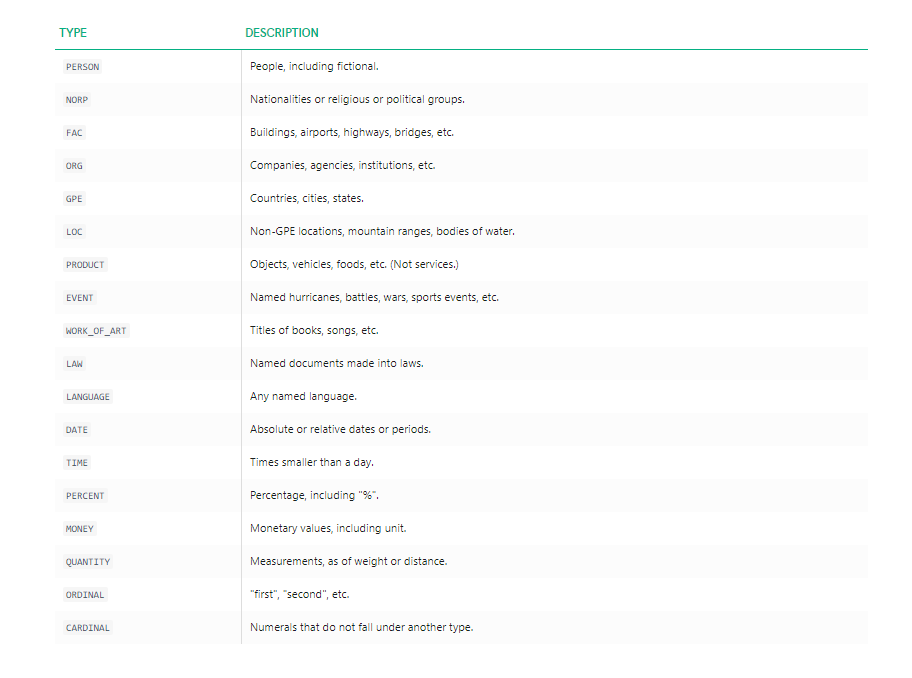

In [25]:
from IPython.display import Image
Image("img/picture.png")

In [26]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

nlp = en_core_web_sm.load()

C:\Users\tshrs\Anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
C:\Users\tshrs\Anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
C:\Users\tshrs\Anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
C:\Users\tshrs\Anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
C:\Users\tshrs\Anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
C:\Users\tshrs\Anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **

In [75]:
#removing duplicates

final_text = df['final_text'].unique()

print('Number of Query Text: ', len(final_text))

Number of Query Text:  63080


In [72]:
corpus = list(nlp.pipe(final_text))


In [74]:
# doc = corpus[2071]
# print(doc)
# print()
# for ent in doc.ents:
#     print(ent.text,ent.label_)

it key metrics data to optimize it costs



In [53]:
# corpus

In [29]:
# Looking at number of times each ent appears in the total corpus
# nb. ents all appear as Spacy tokens, hence needing to cast as str

from collections import defaultdict

all_ents = defaultdict(int)

for i, doc in enumerate(corpus):
    #print(i,doc)
    for ent in doc.ents:
        all_ents[str(ent)] += 1
        #print(ent)
        
print('Number of distinct entities: ', len(all_ents))

Number of distinct entities:  127


In [54]:
# labels = [x.label_ for x in corpus.ents]
# Counter(labels)

ent_label = []
ent_common = []

for i, doc in enumerate(corpus):
    for ent in doc.ents:
        ent_label.append(ent.label_)
        ent_common.append(ent.text)
        
print("Unique labels for entities : ", Counter(ent_label))
print("Top 3 frequent tokens     : ", Counter(ent_common).most_common(3))

Unique labels for entities :  Counter({'CARDINAL': 750, 'DATE': 324, 'GPE': 317, 'ORDINAL': 99, 'NORP': 24, 'TIME': 12, 'QUANTITY': 3, 'ORG': 2})
Top 3 frequent tokens     :  [('china', 269), ('five', 150), ('three', 126)]


In [31]:
sentences = []

for i, doc in enumerate(corpus):
    for ent in doc.sents:
        sentences.append(ent)

print(sentences[0])

adopt best practice become contract negotiation expert data integration tool


In [32]:
# Most popular ents

import operator

sorted_ents = sorted(all_ents.items(), key=operator.itemgetter(1), reverse=True)
sorted_ents[:30]


[('china', 269),
 ('five', 150),
 ('three', 126),
 ('four', 121),
 ('six', 61),
 ('one', 58),
 ('first', 58),
 ('eight', 49),
 ('seven', 46),
 ('first day', 43),
 ('ten', 36),
 ('two', 33),
 ('third', 32),
 ('multiyear', 32),
 ('india', 31),
 ('current year', 30),
 ('annual', 28),
 ('today', 18),
 ('nine', 17),
 ('july', 15),
 ('chinese', 14),
 ('zero', 14),
 ('october', 11),
 ('iot', 11),
 ('year', 10),
 ('five nine', 9),
 ('second', 8),
 ('day', 7),
 ('september', 7),
 ('next year', 7)]

### List of geographies and organizations being mentioned in the search terms.																									

In [37]:
for i, doc in enumerate(corpus):
    for ent in doc.ents:
        if ent.label_ == 'ORG' or ent.label_ == 'GPE':
            print(i, ent.text, ent.start_char, ent.end_char, ent.label_)

442 china 0 5 GPE
570 china 0 5 GPE
729 china 0 5 GPE
904 china 15 20 GPE
943 china 0 5 GPE
960 china 0 5 GPE
977 china 0 5 GPE
1433 china 0 5 GPE
1783 china 0 5 GPE
1934 china 0 5 GPE
2002 china 0 5 GPE
2008 china 0 5 GPE
2071 china 61 66 GPE
2071 india 74 79 GPE
2102 china 0 5 GPE
2102 china 75 80 GPE
2728 china 0 5 GPE
2772 china 0 5 GPE
2812 china 0 5 GPE
3248 china 0 5 GPE
3254 china 0 5 GPE
3399 india 8 13 GPE
3446 china 0 5 GPE
3479 china 0 5 GPE
3492 china 0 5 GPE
4320 china 0 5 GPE
4326 china 0 5 GPE
4372 china 0 5 GPE
4750 china 0 5 GPE
4837 china 0 5 GPE
5011 china 15 20 GPE
5112 china 0 5 GPE
5324 china 15 20 GPE
5683 china 0 5 GPE
5700 china 0 5 GPE
5920 china 0 5 GPE
6101 china 0 5 GPE
6244 china 0 5 GPE
6560 japan 0 5 GPE
6809 china 0 5 GPE
7186 china 0 5 GPE
7276 california 0 10 GPE
7295 china 0 5 GPE
7425 china 0 5 GPE
7458 china 15 20 GPE
7529 china 15 20 GPE
7588 china 15 20 GPE
7769 china 0 5 GPE
7939 india 0 5 GPE
8108 china 0 5 GPE
8196 china 0 5 GPE
8217 china 0 